<a href="https://colab.research.google.com/github/iamyoungjin/Sound-AI/blob/main/Instruments_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import itertools
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [ ]:
!wget http://suanlab.com/datasets/GeneralMidi.wav

--2022-08-09 06:25:37--  http://suanlab.com/datasets/GeneralMidi.wav
Resolving suanlab.com (suanlab.com)... 52.219.58.48
Connecting to suanlab.com (suanlab.com)|52.219.58.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3409459756 (3.2G) [audio/wav]
Saving to: ‘GeneralMidi.wav’

GeneralMidi.wav     100%[===================>]   3.17G  16.7MB/s    in 3m 20s  

2022-08-09 06:28:57 (16.3 MB/s) - ‘GeneralMidi.wav’ saved [3409459756/3409459756]



### Preprocess 

In [ ]:
midi_file = "./GeneralMidi.wav"
instruments = [0,10,20,30,40,50,60,70,80,90]
num_notes = 50
sec = 2
audio = []
inst = []

for inst_idx, note in itertools.product(range(len(instruments)),range(num_notes)):
  instrument = instruments[inst_idx]
  offset = (instrument*num_notes*sec)+(note*sec)
  print(f'instrument:{instrument},note:{note},offset:{offset}')
  y, sr = librosa.load(midi_file, sr=None, offset=offset, duration=2.0)
  audio.append(y)
  inst.append(inst_idx)

instrument:0,note:0,offset:0
instrument:0,note:1,offset:2
instrument:0,note:2,offset:4
instrument:0,note:3,offset:6
instrument:0,note:4,offset:8
instrument:0,note:5,offset:10
instrument:0,note:6,offset:12
instrument:0,note:7,offset:14
instrument:0,note:8,offset:16
instrument:0,note:9,offset:18
instrument:0,note:10,offset:20
instrument:0,note:11,offset:22
instrument:0,note:12,offset:24
instrument:0,note:13,offset:26
instrument:0,note:14,offset:28
instrument:0,note:15,offset:30
instrument:0,note:16,offset:32
instrument:0,note:17,offset:34
instrument:0,note:18,offset:36
instrument:0,note:19,offset:38
instrument:0,note:20,offset:40
instrument:0,note:21,offset:42
instrument:0,note:22,offset:44
instrument:0,note:23,offset:46
instrument:0,note:24,offset:48
instrument:0,note:25,offset:50
instrument:0,note:26,offset:52
instrument:0,note:27,offset:54
instrument:0,note:28,offset:56
instrument:0,note:29,offset:58
instrument:0,note:30,offset:60
instrument:0,note:31,offset:62
instrument:0,note:32,of

In [ ]:
len(inst)

500

In [ ]:
import numpy as np
audio_np = np.array(audio, np.float32)
inst_np = np.array(inst, np.float32)

print(audio_np.shape, inst_np.shape)

(500, 88200) (500,)


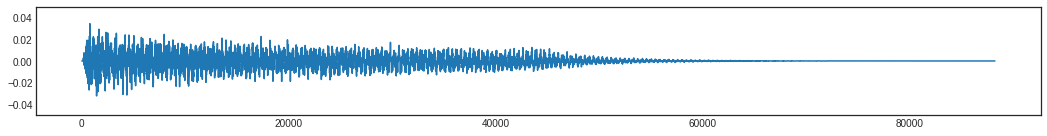

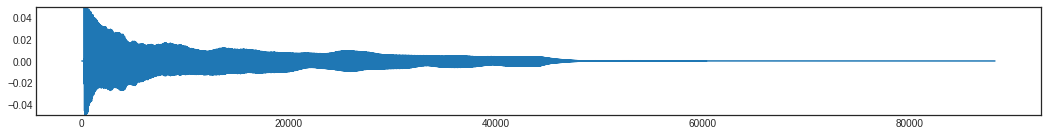

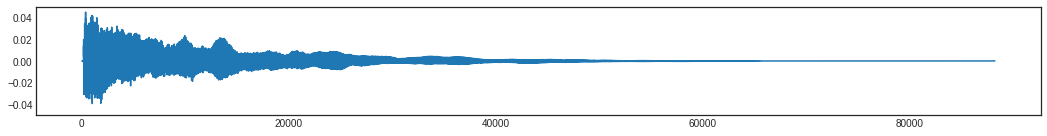

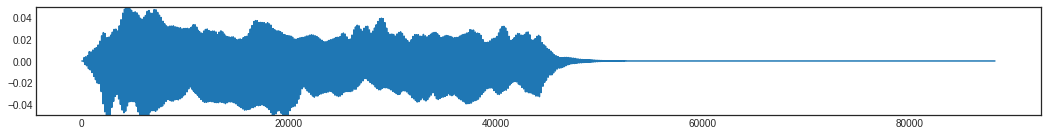

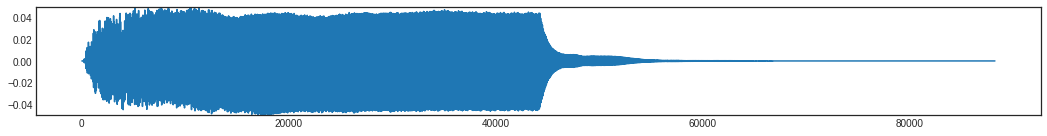

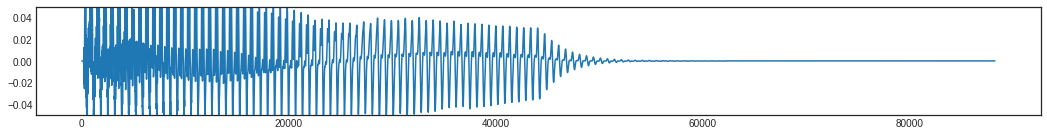

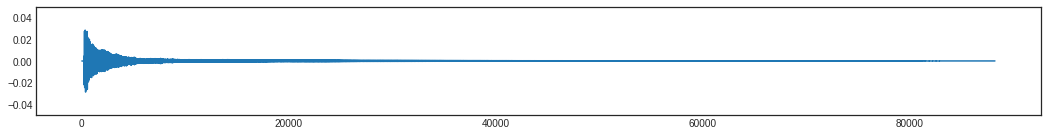

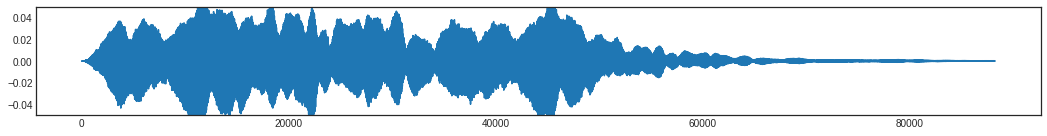

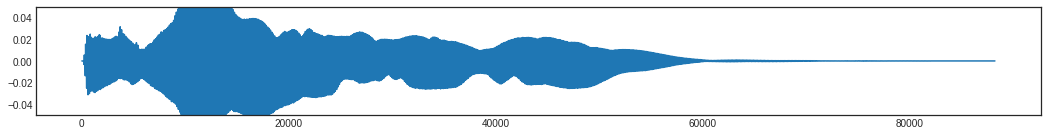

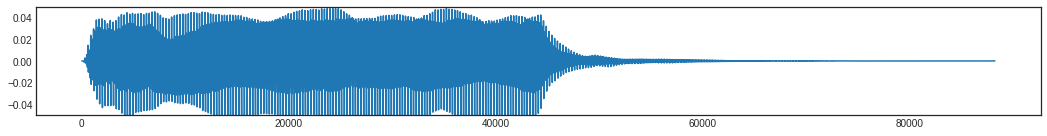

In [ ]:
#악기종류에 따라 waveform이 다르다는 것을 파악할 수 있다
for idx in range(0, len(audio_np), num_notes):
  plt.figure(figsize=(18,2))
  plt.plot(audio_np[idx])
  plt.ylim((-0.05, 0.05))
  plt.show()

In [ ]:
ipd.Audio(audio_np[0],rate=sr)
# ipd.Audio(audio_np[50],rate=sr)
# ipd.Audio(audio_np[100],rate=sr)

In [ ]:
#Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(audio_np)

MinMaxScaler()

In [ ]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(audio_np, inst_np, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 88200)
(100, 88200)
(400,)
(100,)


## 단순  audio를 npy 시킨 데이터 테스트 

In [ ]:
#LR은 다중분류에 적합하지않지만 시험삼아 해보았다
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR = LogisticRegression()
LR.fit(train_x, train_y)
pred = LR.predict(test_x)
acc =accuracy_score(pred, test_y)
print(acc)

0.08


In [ ]:
from sklearn import  svm
SVM = svm.SVC(kernel='linear')
SVM.fit(train_x,  train_y)
pred  = SVM.predict(test_x)
acc =accuracy_score(pred, test_y)
print(acc)

0.1


결론적으로 acc가 안좋은 이유는, 88200라는 긴 길이의 데이터를 잘 처리 하지 못하는거 같다

# Constant-Q를 이용한 오디오 분류

wav는 음압을 측정하여 수치를 저장한 것이다.   
우리는 음압을 듣는게 아니라, 소리의 높이와 세기를 듣는 것이기 때문에, 푸리에변환같은 변환이 필요하다.   음악을 처리하는데에는 Constant-Q가 푸리에 변환보다 유리하다고 한다.   
(주파수 축이 로그단위로 변환 되고, 각 주파수에따라  해상도가 다양하게 처리되기 때문에

In [ ]:
#n_bins: 옥타브의 단계 및 개수
#bins_per_octave: 한 옥타브가 가지는 단계
audio_cqt = []
for y in audio:
  ret = librosa.cqt(y,sr,hop_length=1024,n_bins=24*7,bins_per_octave=24)
  ret = np.abs(ret)
  audio_cqt.append(ret)

/usr/local/lib/python3.7/dist-packages/librosa/display.py:1336: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  "Frequency axis exceeds Nyquist. "


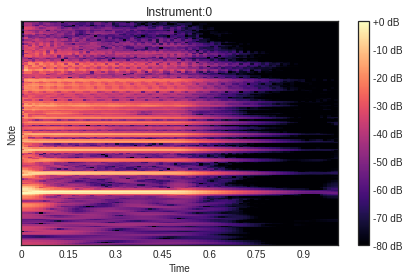

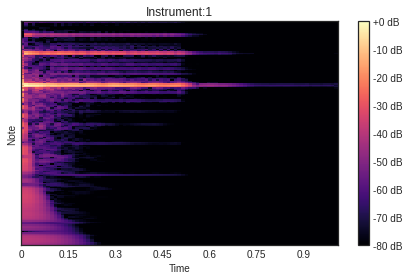

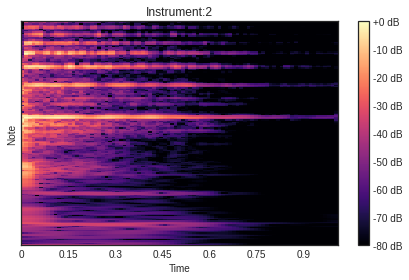

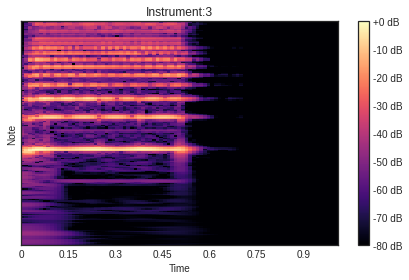

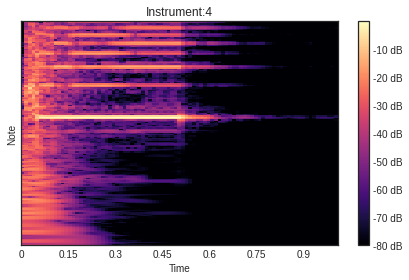

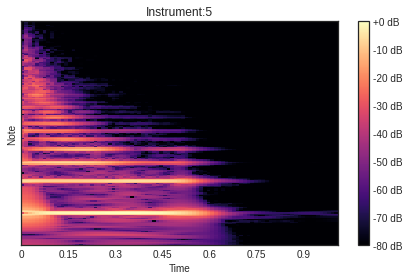

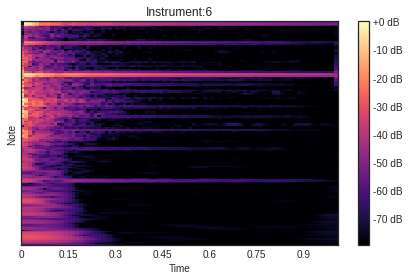

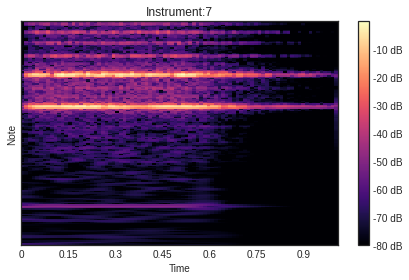

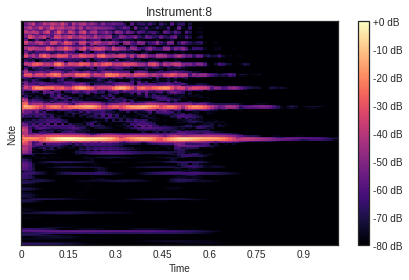

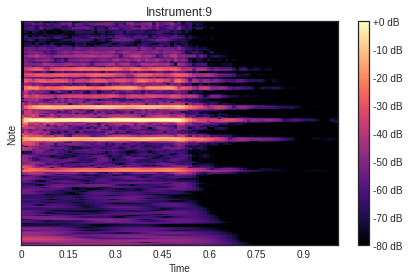

In [ ]:
for i in range(0,len(instruments)*num_notes, num_notes): # 0,500, 50
  amp_db = librosa.amplitude_to_db(np.abs(audio_cqt[i]),ref=np.max)
  librosa.display.specshow(amp_db,sr=sr, x_axis='time',y_axis='cqt_note')
  plt.colorbar(format='%+2.0f dB')
  plt.title(f'Instrument:{inst[i]}')
  plt.tight_layout()
  plt.show()

In [ ]:
cqt_np = np.array(audio_cqt, np.float32)
inst_np = np.array(inst, np.int16)
print(cqt_np.shape, inst_np.shape)

(500, 168, 87) (500,)


In [ ]:
#DNN사용 입력값을 위해 3차원 벡터를 2차원 벡터로 변환
cqt_np = cqt_np.reshape((500,168*87))

In [ ]:
#읽어온 데이터는 음량이나 범위가 다를 수 있기 때문에 데이터 범위 조정 필요
#Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(cqt_np)

MinMaxScaler()

In [ ]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(cqt_np, inst_np, test_size=0.2)

#npy(88200) -> 14616으로 줄었다
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 14616)
(100, 14616)
(400,)
(100,)


In [ ]:
#SVM 테스트시 결과가 아까보다는 좋아진걸 볼 수 있다
from sklearn import  svm
SVM = svm.SVC(kernel='linear')
SVM.fit(train_x,  train_y)
pred  = SVM.predict(test_x)
acc =accuracy_score(pred, test_y)
print(acc)

0.25


# 분류 DNN

In [ ]:
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

cqt_np = np.array(audio_cqt, np.float32)
cqt_np = cqt_np.reshape((500,168*87))
cqt_array =  np.expand_dims(cqt_np,-1)
inst_cat = to_categorical(inst_np)

train_x, test_x, train_y, test_y = train_test_split(cqt_array, inst_cat, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 14616, 1)
(100, 14616, 1)
(400, 10)
(100, 10)


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense

def model_build():
  model = Sequential()
  input = Input(shape=(14616,), name="input")
  output = Dense(512, activation='relu', name='hidden1')(input)
  output = Dense(256, activation='relu', name='hidden2')(output)
  output = Dense(128, activation='relu', name='hidden3')(output)
  output = Dense(10, activation='softmax', name='output')(output)

  model = Model(inputs=[input], outputs = output)

  model.compile(optimizer = 'adam',
                loss='categorical_crossentropy',
                metrics=['acc'])
  
  return model

In [ ]:
model = model_build()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 14616)]           0         
                                                                 
 hidden1 (Dense)             (None, 512)               7483904   
                                                                 
 hidden2 (Dense)             (None, 256)               131328    
                                                                 
 hidden3 (Dense)             (None, 128)               32896     
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 7,649,418
Trainable params: 7,649,418
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_x,  train_y, epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30
3/3 [==============================] - 3s 93ms/step - loss: 2.2356 - acc: 0.1094 - val_loss: 2.0891 - val_acc: 0.1625
Epoch 2/30
3/3 [==============================] - 0s 18ms/step - loss: 1.8450 - acc: 0.3875 - val_loss: 1.8358 - val_acc: 0.3000
Epoch 3/30
3/3 [==============================] - 0s 21ms/step - loss: 1.5232 - acc: 0.5281 - val_loss: 1.6827 - val_acc: 0.3250
Epoch 4/30
3/3 [==============================] - 0s 18ms/step - loss: 1.2210 - acc: 0.6500 - val_loss: 1.8125 - val_acc: 0.2875
Epoch 5/30
3/3 [==============================] - 0s 19ms/step - loss: 0.9903 - acc: 0.7406 - val_loss: 1.9040 - val_acc: 0.3125
Epoch 6/30
3/3 [==============================] - 0s 18ms/step - loss: 0.7842 - acc: 0.7844 - val_loss: 2.1977 - val_acc: 0.3000
Epoch 7/30
3/3 [==============================] - 0s 19ms/step - loss: 0.6397 - acc: 0.8156 - val_loss: 2.4222 - val_acc: 0.3250
Epoch 8/30
3/3 [==============================] - 0s 19ms/step - loss: 0.5005 - acc: 0.8750 - val

In [ ]:
def plot_history(history_dict):
  loss =history_dict['loss']
  val_loss =   history_dict['val_loss']

  epochs = range(1, len(loss)+1)
  fig = plt.figure(figsize=(14,5))

  ax1  =fig.add_subplot(1,2,1)
  ax1.plot(epochs, loss, 'b--', label='train_loss')
  ax1.plot(epochs, val_loss, 'r', label='val_loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.grid()
  ax1.legend()

  acc = history_dict['acc']
  val_acc = history_dict['val_acc']

  ax2  =fig.add_subplot(1,2,2)
  ax2.plot(epochs, acc, 'b--', label='train_acc')
  ax2.plot(epochs, val_acc, 'r', label='val_acc')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.grid()
  ax2.legend()

  plt.show()

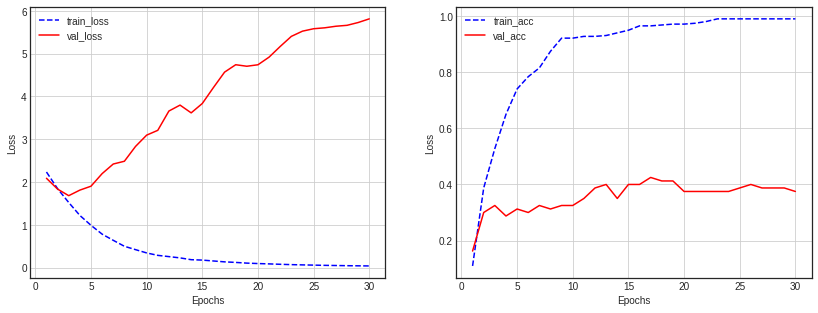

In [ ]:
plot_history(history.history)

In [ ]:
model.evaluate(test_x, test_y)

4/4 [==============================] - 0s 5ms/step - loss: 6.1744 - acc: 0.3400


[6.174373626708984, 0.3400000035762787]

# CNN 

In [ ]:
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

cqt_np = np.array(audio_cqt, np.float32)
# cqt_np = cqt_np.reshape((500,168*87))
cqt_array =  np.expand_dims(cqt_np,-1)
inst_cat = to_categorical(inst_np)

train_x, test_x, train_y, test_y = train_test_split(cqt_array, inst_cat, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 168, 87, 1)
(100, 168, 87, 1)
(400, 10)
(100, 10)


In [ ]:
from keras.layers import Conv2D, MaxPool2D, Flatten

def model_build():
  model = Sequential()

  input = Input(shape=(168,87,1))
  output = Conv2D(128,3,strides=1, padding='same', activation='relu')(input)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)

  output = Conv2D(256,3,strides=1, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)

  output = Conv2D(512,3,strides=1, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)

  output = Flatten()(output)
  output = Dense(512,activation='relu')(output)
  output = Dense(256,activation='relu')(output)
  output = Dense(128,activation='relu')(output)
  output = Dense(10,activation='softmax')(output)

  model = Model(inputs=[input], outputs= output)

  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['acc'])
  
  return model

In [ ]:
model = model_build()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 168, 87, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 168, 87, 128)      1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 44, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 44, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 22, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 42, 22, 512)       1180

In [ ]:
history = model.fit(train_x, train_y, epochs=20, batch_size=128, validation_split=0.2)

Epoch 1/20
3/3 [==============================] - 126s 36s/step - loss: 2.2352 - acc: 0.1344 - val_loss: 1.8635 - val_acc: 0.3375
Epoch 2/20
3/3 [==============================] - 91s 29s/step - loss: 1.7499 - acc: 0.3781 - val_loss: 1.4198 - val_acc: 0.4000
Epoch 3/20
3/3 [==============================] - 91s 29s/step - loss: 1.2701 - acc: 0.5219 - val_loss: 1.2489 - val_acc: 0.5625
Epoch 4/20
3/3 [==============================] - 91s 28s/step - loss: 0.9585 - acc: 0.7125 - val_loss: 1.2041 - val_acc: 0.5750
Epoch 5/20
3/3 [==============================] - 92s 28s/step - loss: 0.7490 - acc: 0.7406 - val_loss: 0.7156 - val_acc: 0.7750
Epoch 6/20
3/3 [==============================] - 91s 28s/step - loss: 0.5869 - acc: 0.7844 - val_loss: 1.2383 - val_acc: 0.7250
Epoch 7/20
3/3 [==============================] - 91s 29s/step - loss: 0.5161 - acc: 0.8344 - val_loss: 1.4640 - val_acc: 0.7000
Epoch 8/20
3/3 [==============================] - 92s 29s/step - loss: 0.5172 - acc: 0.8406 - va

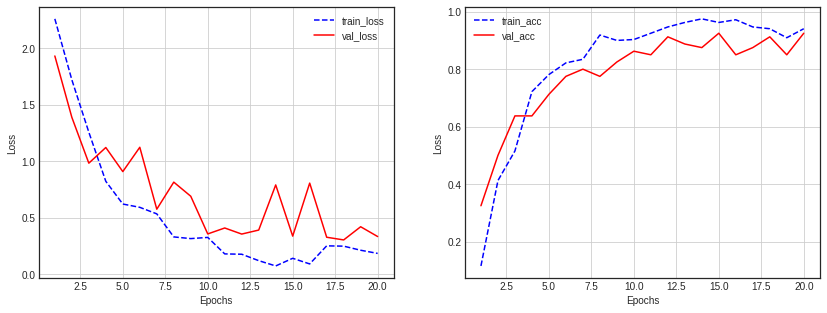

In [ ]:
plot_history(history.history)

# MFCC를 이용한 머신러닝 오디오 분류

In [ ]:
audio_mfcc = []
for y in audio:
  ret =  librosa.feature.mfcc(y=y,sr=sr)
  audio_mfcc.append(ret)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9839 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9839 missing from current font.
  font.set_text(s, 0, flags=flags)


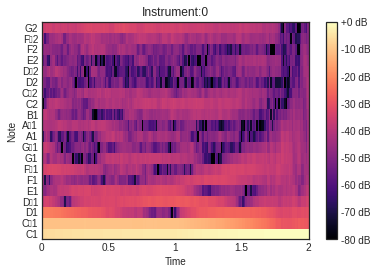

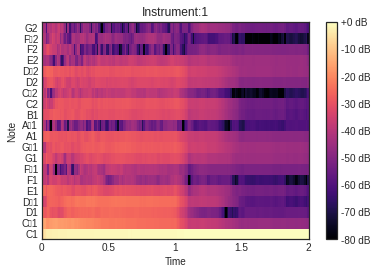

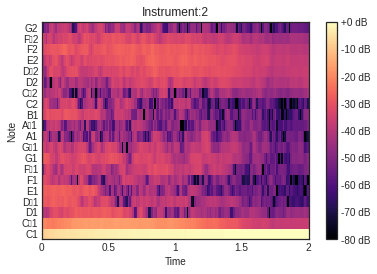

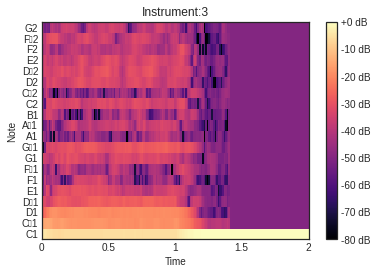

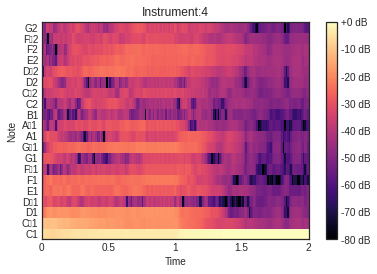

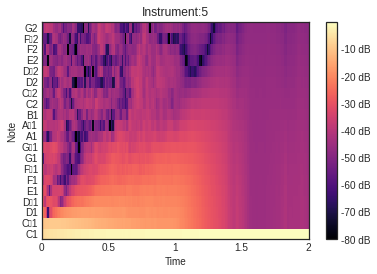

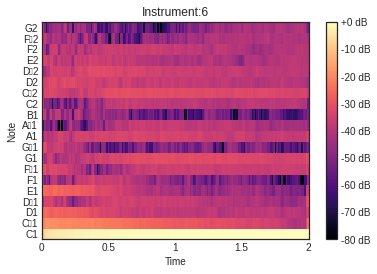

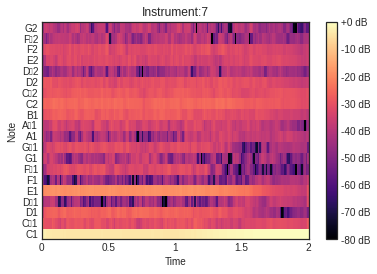

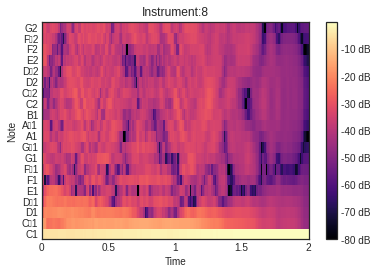

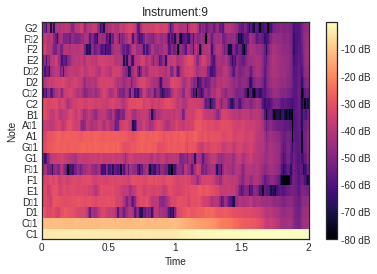

In [ ]:
for i in range(0, len(instruments)*num_notes, num_notes):
  amp_db = librosa.amplitude_to_db(np.abs(audio_mfcc[i]),ref=np.max)
  librosa.display.specshow(amp_db,sr=sr,x_axis='time',y_axis='cqt_note')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Instrument:{}'.format(inst[i]))
  # plt.tight_layout()
  plt.show()

In [ ]:
mfcc_np = np.array(audio_mfcc, np.float32)
inst_np = np.array(inst, np.int16)

print(mfcc_np.shape, inst_np.shape)  #이전보다 더 작은 shape이 가능 

(500, 20, 173) (500,)


In [ ]:
mfcc_np = mfcc_np.reshape((500,20*173))

In [ ]:
#Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(mfcc_np)

MinMaxScaler()

In [ ]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(mfcc_np, inst_np, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 3460)
(100, 3460)
(400,)
(100,)


In [ ]:
#SVM test
from sklearn import  svm
SVM = svm.SVC(kernel='linear')
SVM.fit(train_x,  train_y)
pred  = SVM.predict(test_x)
acc =accuracy_score(pred, test_y)
print(acc)

0.97


# CNN

In [ ]:
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

mfcc_np = np.array(audio_mfcc, np.float32)
mfcc_array =  np.expand_dims(mfcc_np,-1)
inst_cat = to_categorical(inst_np)

train_x, test_x, train_y, test_y = train_test_split(mfcc_array, inst_cat, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 20, 173, 1)
(100, 20, 173, 1)
(400, 10)
(100, 10)


In [ ]:
from keras.layers import Conv2D, MaxPool2D, Flatten

def model_build():
  model = Sequential()

  input = Input(shape=(20,173,1))
  output = Conv2D(128,3,strides=1, padding='same', activation='relu')(input)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)

  output = Conv2D(256,3,strides=1, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)

  output = Conv2D(512,3,strides=1, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)

  output = Flatten()(output)
  output = Dense(512,activation='relu')(output)
  output = Dense(256,activation='relu')(output)
  output = Dense(128,activation='relu')(output)
  output = Dense(10,activation='softmax')(output)

  model = Model(inputs=[input], outputs= output)

  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['acc'])
  
  return model

In [ ]:
model = model_build()
history = model.fit(train_x, train_y, epochs=20, batch_size=128, validation_split=0.2)

Epoch 1/20
3/3 [==============================] - 3s 603ms/step - loss: 65.9432 - acc: 0.1219 - val_loss: 51.8115 - val_acc: 0.1875
Epoch 2/20
3/3 [==============================] - 0s 82ms/step - loss: 31.3572 - acc: 0.1219 - val_loss: 3.8327 - val_acc: 0.0875
Epoch 3/20
3/3 [==============================] - 0s 81ms/step - loss: 2.9796 - acc: 0.1187 - val_loss: 2.3084 - val_acc: 0.0500
Epoch 4/20
3/3 [==============================] - 0s 80ms/step - loss: 2.2902 - acc: 0.1437 - val_loss: 2.2079 - val_acc: 0.0625
Epoch 5/20
3/3 [==============================] - 0s 80ms/step - loss: 2.1217 - acc: 0.2313 - val_loss: 1.9999 - val_acc: 0.2375
Epoch 6/20
3/3 [==============================] - 0s 80ms/step - loss: 1.8775 - acc: 0.2875 - val_loss: 2.0585 - val_acc: 0.1875
Epoch 7/20
3/3 [==============================] - 0s 79ms/step - loss: 1.6434 - acc: 0.3969 - val_loss: 1.5653 - val_acc: 0.4750
Epoch 8/20
3/3 [==============================] - 0s 79ms/step - loss: 1.3854 - acc: 0.5281 -

# Summary what I learned
#### Audio Feature를 뭘 사용하느냐가 중요하다는 걸 알 수 있다.